# Code for fitting Astro RC data

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
import pandas as pd
import pystan

import os
import pickle

#from omnitool.literature_values import *
from omnitool import spyglass

import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_data():
#     sfile = '../Data/MRCxyu18.csv'
    sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [3]:
df = read_data()
df.head(2)
print('Size: '+str(len(df)))

Size: 7725


#### Gather the relevant data

In [4]:
sg = spyglass()
sg.pass_position(df.ra, df.dec, frame='icrs')
sg.pass_distance(df.r_est, err=df.r_err)
sg.band = 'Ks'
df['Ak'] = sg.get_Aband()

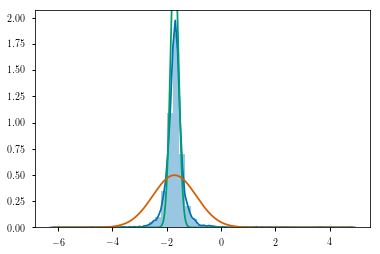

-1.6975076194980592


In [5]:
'''Step one is figuring out the different distributions we want'''
aKs = df.ast_MKs.values
pKs = df.phot_MKs.values
stage = df.stage.values
mKs = df.kmag.values
heb = stage == 2

px = np.linspace(pKs.min(),pKs.max(),1000)


pfg = normal(px, np.median(aKs), 0.15)
pbg = normal(px, np.median(aKs), .8)

sns.distplot(pKs)
plt.plot(px,pfg)
plt.plot(px,pbg)
plt.show()

print(np.median(pKs))

## Stan model for astrometric values

In [8]:
overwrite = True
asterostan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    real m[N];
    real <lower=0> m_err[N];
    real oo[N];
    real oo_err[N];
    
    //real <lower=1> r[N];
    real <lower=0> RlEbv[N];
}

parameters {
    //Hyperparameters
    real mu;
    real muo;
    real <lower=0.> sigma;
    real <lower=0.> sigo;
    real <lower=0.,upper=1.> Q;
    real <lower=.1, upper=4000.> L;
    
    //Latent parameters
    real M_infd_std[N];
    real Ai[N];
    real<lower=1> r_infd[N];
}

transformed parameters{
    //'True' parameters
    real m_true[N];
    real oo_true[N];
    
    //Inferred and transformed parameters
    real M_infd[N];
    real tmuo;
    real<lower=0.> tsigo;
    
    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma*M_infd_std[n]; //Rescale the M fit
        oo_true[n] = 1000./r_infd[n];
        m_true[n] = M_infd[n] + 5.*log10(r_infd[n]) - 5 + Ai[n];
    }
    tmuo = muo - mu;
    tsigo = sigo / sigma;
}

model {
    //Observables
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
    oo ~ normal(oo_true, oo_err);
    
    //Hyperparameters in true space
    mu ~ normal(-1.71, .1);
    sigma ~ normal(.1, .05);
    Q ~ normal(.95, .01);
    muo ~ normal(-1.71, .01);
    sigo ~ normal(1., .1);
    
    //Latent parameters in true space
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
    }
    //Mixture model (in transformed space)
    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0, 1),
            normal_lpdf(M_infd_std[n] | tmuo, tsigo));
            
    //Unmarginalized likelihood (in true space)
    for (n in 1:N){
    target += m[n] * oo[n];
    }
}

'''

model_path = 'astrostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='astrostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='astrostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL astrostan_0d22aeb6bc90a18057ad2632d9d7dfb3 NOW.


Updating Stan model


#### Run the model

In [9]:
sel = df[:1000]
m = sel.kmag.values
m_err = np.ones(len(sel)) * 0.1
oo = sel.parallax.values
oo_err = sel.parallax_error.values
RlEbv = sel.Ak.values

M_err = sel.phot_MKs_err #For plotting purposes

dat = {'N': len(sel),
        'm': m,
        'm_err' : m_err,
        'oo' : oo,
        'oo_err' : oo_err,
        'RlEbv':RlEbv}

init = [{'mu':-1.69,
       'sigma':0.2,
       'Q': 0.95,
       'muo':-1.69,
       'sigo':1.,
        'L' : 220.}]

fit = sm.sampling(data=dat, iter=2000, chains=1, init=init)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


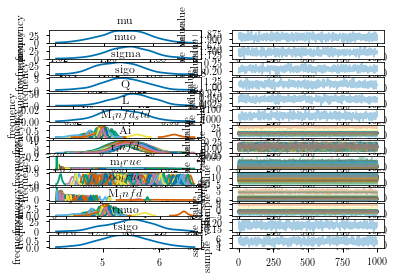

In [10]:
fit.plot()
plt.show()

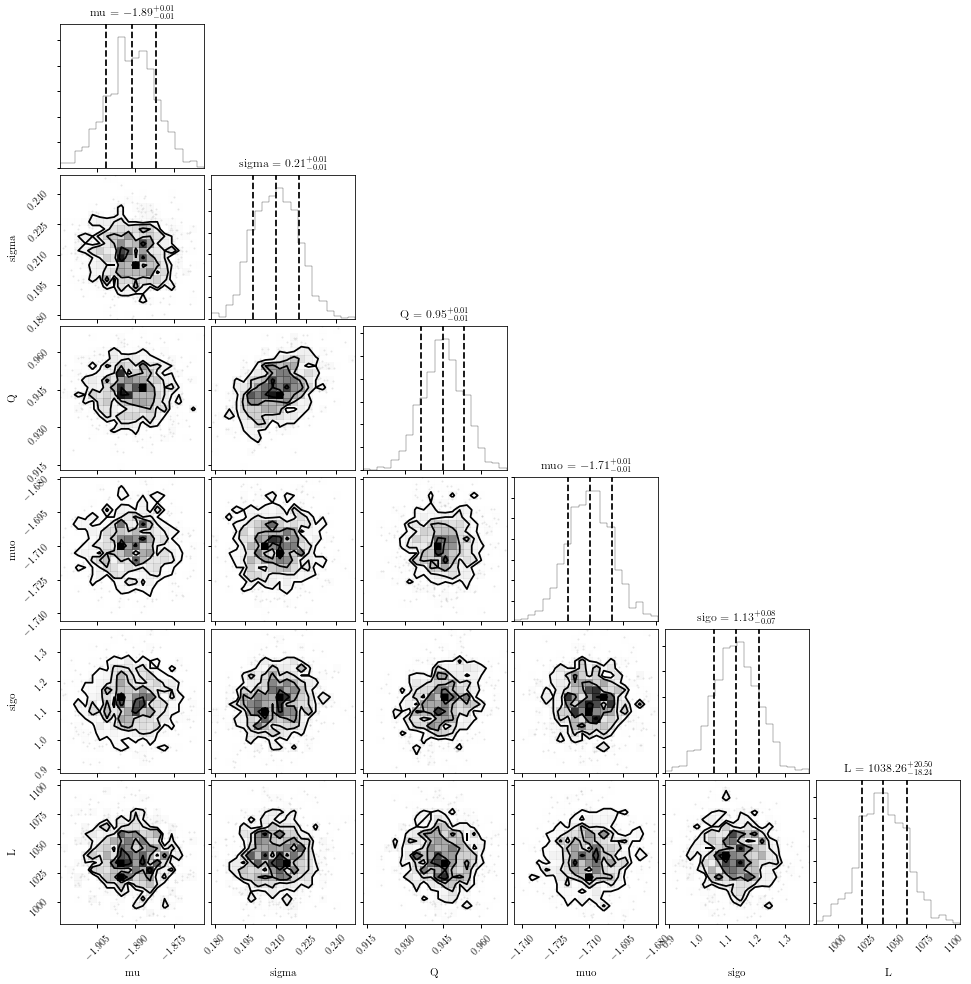

In [11]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['muo'],fit['sigo'],fit['L']])
corner.corner(chain.T,labels=['mu','sigma','Q','muo','sigo','L'],\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [12]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
muo = np.median(fit['muo'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])
Minfd = np.median(fit['M_infd'],axis=0)
rinfd = np.median(fit['r_infd'],axis=0)
# tpp = fit['post_prob']
# bpp = fit['bg_pp']
# post_prob = np.sum(tpp,axis=0)/tpp.shape[0]
# bg_pp = np.sum(bpp,axis=0)/bpp.shape[0]
fg = normal(Minfd, mu, sigma)
bg = normal(Minfd, muo, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

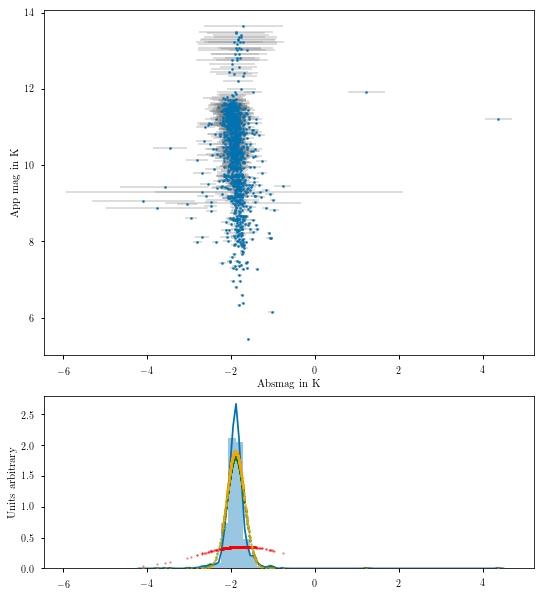

In [13]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

# cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(Minfd,m,s=5,zorder=1000)#,c=post_prob,zorder=1000)
# fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(Minfd,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(Minfd,ax=xax)

xax.scatter(Minfd,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(Minfd,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(Minfd, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

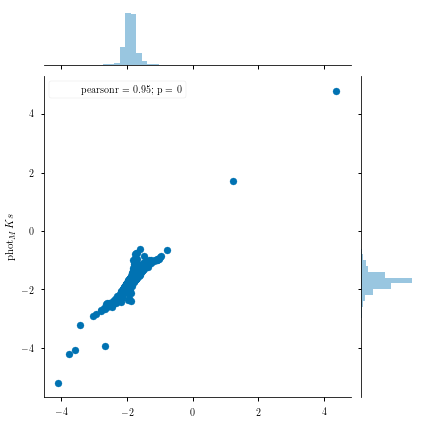

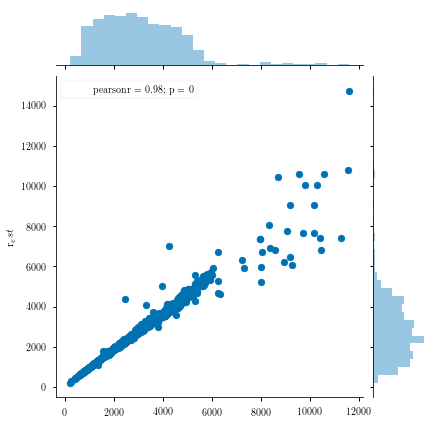

In [14]:
'''Now lets quickly compare the inferred value of M and the omnitool value'''
sns.jointplot(Minfd, sel.phot_MKs)
plt.show()
sns.jointplot(rinfd, sel.r_est)
plt.show()

Total number of Rhats: 6009
Total number of Rhats with the NaN values removed: 6009


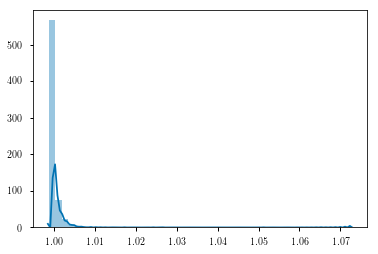

In [15]:
s = fit.summary()
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [16]:
print(fit)

Inference for Stan model: astrostan_0d22aeb6bc90a18057ad2632d9d7dfb3.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.89  4.0e-4 9.6e-3  -1.91   -1.9  -1.89  -1.88  -1.87  567.0   1.01
muo              -1.71  3.2e-4   0.01  -1.73  -1.72  -1.71   -1.7  -1.69 1000.0    1.0
sigma             0.21  9.0e-4   0.01   0.19    0.2   0.21   0.22   0.23  152.0    1.0
sigo              1.13  2.4e-3   0.08   0.97   1.08   1.13   1.18   1.27 1000.0    1.0
Q                 0.94  4.5e-4 8.3e-3   0.93   0.94   0.95   0.95   0.96  347.0    1.0
L               1038.8    0.63  19.96 998.15 1025.4 1038.2 1052.7 1078.2 1000.0    1.0
M_infd_std[0]     0.72    0.02   0.59  -0.35   0.31   0.71   1.11   1.96 1000.0    1.0
M_infd_std[1]    -0.98    0.02   0.61  -2.25  -1.39  -0.96  -0.58   0.16  992.0    1.0
M_infd_std[2]    -0.14    0.0

### Temporarily redundant code

In [ ]:
sys.exit()